# Introduction

In this notebook, we are going to demonstrate how to use ChatGPT API 
- to build a single-turn QA system, 
- a multi-turn dialogue system, 
- and a retrieval-augmented multi-turn dialogue system. 

## ChatGPT API 

- We are going to use [ChatCompletion](https://platform.openai.com/docs/api-reference/chat/create).

- The core function of ChatCompletion is designed for dialogue.

- Below lists the parameters of ChatCompletion.create

Image from: https://zhuanlan.zhihu.com/p/645348187

In [44]:
!pip install transformers
!pip install hnswlib

In [45]:
import os
import time
import traceback
import tiktoken
import glob

# input your key!
import openai
openai.api_type = ''
openai.api_base = ''
openai.api_version = ''
openai.api_key = ''
engine=''


from IPython.display import Image
import sys
sys.path.append('.')

from sentence_transformers import SentenceTransformer, util

import hnswlib

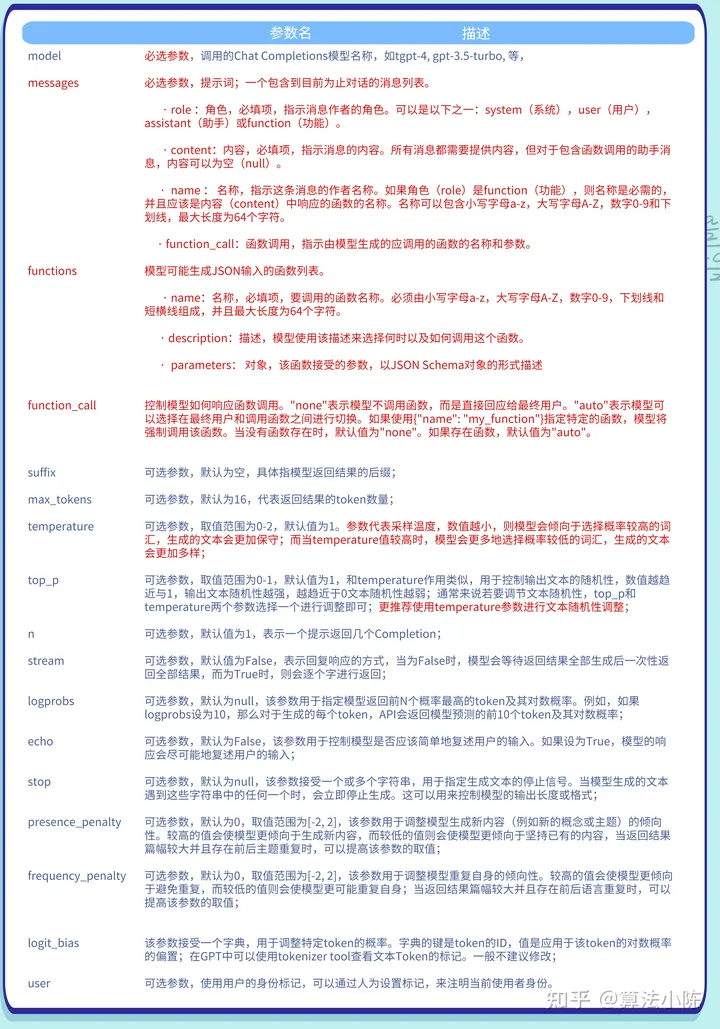

In [22]:
Image(filename="/Users/lid5/Documents/Project/openai/images/ChatCompletionParam.jpg")

# Single-turn Question Answering

- There are 3 roles in parameter `messages`: `user`, `system`, `assistant`.
    * if the role of a message is user，it means user sends message to the system. 
    * if the role of a message is assistant，it means the ChatGPT model does inference/reasoning over user's last message and gives response. assisstant message and user message are 1-1 mapping.
    * if the role of a message is system, it means to set a a global identity or context for the ChatGPT model.
    
For QA, we only use the user role.

In [34]:
prompt = '''What is Amsterdam known for?'''
response=openai.ChatCompletion.create(engine=engine,
                                            model="gpt-3.5-turbo",
                                            temperature=0.1,
                                            max_tokens=100,   
                                            messages=[{"role":"user","content":prompt}])

text = response.choices[0]["message"]["content"] 
print(text)

Amsterdam is known for its beautiful canals, historic architecture, world-class museums, vibrant nightlife, and liberal attitudes towards drugs and sexuality. It is also famous for its coffee shops, where marijuana is legally sold and consumed, and its red-light district, where prostitution is legal and regulated. Additionally, Amsterdam is known for its cycling culture, with many locals using bicycles as their primary mode of transportation.


# Multi-turn dialogue

Main idea: 
- use `while` to continue asking
- use `input()` method to capture user's input
- use `list.append()` for accumulate history messages 

Reference: https://juejin.cn/post/7217360688263004217


In [38]:
messages = []

while True:
    content = input("User: ")
    messages.append({"role": "user", "content": content})
    
    completion = openai.ChatCompletion.create(
        engine=engine,
      model="gpt-3.5-turbo",
      messages=messages
    )

    chat_response = completion
    answer = chat_response.choices[0].message.content

    messages.append({"role": "assistant", "content": answer})
    
    print(str(messages[-1])+'\n\n')
    
    # if finish dialogue
    if 'bye' in content.lower():
        break


User: What is Amsterdam known for?
{'role': 'assistant', 'content': 'Amsterdam is known for its beautiful canals, historic architecture, laid-back café culture, and vibrant nightlife. It is also famously liberal and tolerant, with a thriving LGBTQ+ community. Other things Amsterdam is known for include its museums (such as the Rijksmuseum and Van Gogh Museum), its famous red-light district, its bicycles, and its delicious food (including stroopwafels, herring, and Dutch cheese).'}


User:  Give me the top 3 museums and their prices and addresses. Put them in a table.
{'role': 'assistant', 'content': "Here are the top 3 museums in Amsterdam with their prices and addresses:\n\n| Museum Name | Address | Price Range (in Euros) |\n| --- | --- | --- |\n| Rijksmuseum | Museumstraat 1, 1071 XX Amsterdam | 20-25 |\n| Van Gogh Museum | Museumplein 6, 1071 DJ Amsterdam | 19-23 |\n| Anne Frank House | Prinsengracht 263-267, 1016 GV Amsterdam | 10-15 |\n\nNote: Price ranges are subject to change an

# Retrieval-augmented multi-turn dialogue system

## 1. build the retrieval module
- We use the [BBC Dataset](http://mlg.ucd.ie/datasets/bbc.html) as an example corpus.
- We use BiEncoder in [Sbert](https://www.sbert.net/) as the Encoder model.

In [43]:
# load corpus
docs = []

for file in glob.glob('./bbc_corpus/tech/*.txt'):
    with open(file) as f:
        docs.append(str(f.read()))
print(f'{len(docs)} docs.')

401 docs.


In [46]:
# load model
model = SentenceTransformer('all-MiniLM-L6-v2') 

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [47]:
# encode texts
embeddings = model.encode(docs)

In [49]:
%%time
# build index 

dim = len(embeddings[0])
print('Vector dim: {}'.format(dim))

ids = list(range(len(embeddings)))
num_elements = len(ids)

# Declaring index
index = hnswlib.Index(space = 'ip', dim = dim) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
index.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

# Element insertion (can be called several times):
index.add_items(embeddings, ids)

# Controlling the recall by setting ef:
index.set_ef(50) # ef should always be > k

Vector dim: 384
CPU times: user 57.2 ms, sys: 13.8 ms, total: 71 ms
Wall time: 10.6 ms


In [51]:
# search

query = 'Movies from Sony Pictures'    
query_vector = model.encode(query)
labels, distances = index.knn_query(query_vector, k = 3)  # retrieve top-3 documents
for label in labels.flatten():
    print('ID: {}\nText: {}\n\n'.format(label, docs[label][:300]))
    

ID: 274
Text: More movies head to Sony's PSP

Movies Open Water and Saw are among those to be made available for Sony's PSP games console.

Film studio Lions Gate entertainment has announced an initial list of 12 movies that will be on the UMD format used by the handheld. "The typical buyer of the machine [is] th


ID: 261
Text: Disney backs Sony DVD technology

A next generation DVD technology backed by Sony has received a major boost.

Film giant Disney says it will produce its future DVDs using Sony's Blu-ray Disc technology, but has not ruled out a rival format developed by Toshiba. The two competing DVD formats, Blu-ra


ID: 287
Text: Disney backs Sony DVD technology

A next generation DVD technology backed by Sony has received a major boost.

Film giant Disney says it will produce its future DVDs using Sony's Blu-ray Disc technology, but has not ruled out a rival format developed by Toshiba. The two competing DVD formats, Blu-ra




## 2. build RAG-based dialogue

In [56]:
messages = []

while True:
    query = input("User: ")
    
    
    # insert RAG module here
    query_vector = model.encode(query)
    labels, distances = index.knn_query(query_vector, k = 3) 
    rel_docs = [docs[label] for label in labels.flatten()]
    
    content = 'You are given a list of contextual documents below:\n'
    for i, rel_doc in enumerate(rel_docs):
        content += f'Document {i}: {rel_doc}\n'
    
    print('[chatgpt prompt]', content)
    
    # original dialogue module
    content +=f'Generate a response considering the given contextual documents: {query}.\nThe response should be concise, easy to understand, about 50 to 100 words.'
    messages.append({"role": "user", "content": content})
    
    completion = openai.ChatCompletion.create(
        engine=engine,
      model="gpt-3.5-turbo",
      messages=messages
    )

    chat_response = completion
    answer = chat_response.choices[0].message.content

    messages.append({"role": "assistant", "content": answer})
    
    print(str(messages[-1])+'\n\n')
    
    # if finish dialogue
    if 'bye' in content.lower():
        break


User: Tell me about Blu-ray.
[chatgpt prompt] You are given a list of contextual documents below:
Document 0: Games win for Blu-ray DVD format

The next-generation DVD format Blu-ray is winning more supporters than its rival, according to its backers.

Blu-ray, backed by 100 firms including Sony, is competing against Toshiba and NEC-backed HD-DVD to be the format of choice for future films and games. The Blu-Ray Association said on Thursday that games giants Electronic Arts and Vivendi would both support its DVD format. The next generation of DVDs will hold high-definition video and sound. This offers incredible 3D-like quality of pictures which major Hollywood studios and games publishers are extremely keen to exploit in the coming year. In a separate press conference at the Consumer Electronics Show in Las Vegas, Toshiba announced that DVD players for its technology would be on the market by the end of 2005.

"As we move from standard definition video images to high-definition images

{'role': 'assistant', 'content': 'Blu-ray is a next-generation DVD format backed by Sony and over 100 other firms, including major Hollywood studios and technology companies like Samsung and Dell. It offers high-definition video and sound, with the ability to store up to 50GB of data on a single disc - six times more than current DVDs. Gaming giants Electronic Arts and Vivendi have also announced support for Blu-ray, recognizing its capacity and functionality for immersive gaming experiences. Blu-ray is competing against Toshiba and NEC-backed HD-DVD to be the format of choice for future films and games.'}


User: What is the market share of Blu-ray?
[chatgpt prompt] You are given a list of contextual documents below:
Document 0: Games win for Blu-ray DVD format

The next-generation DVD format Blu-ray is winning more supporters than its rival, according to its backers.

Blu-ray, backed by 100 firms including Sony, is competing against Toshiba and NEC-backed HD-DVD to be the format of c

{'role': 'assistant', 'content': "Blu-ray, a next-generation DVD format backed by over 100 firms including Sony and major Hollywood studios, currently has a significant market share in the format battle against Toshiba's HD-DVD. Disney recently announced that it will produce its future DVDs using Sony's Blu-ray Disc technology, contributing to the format's success. Twentieth Century Fox is yet to announce its support, but if it also backs Blu-ray, the format would reach a 47% share of DVD content. The market for high-definition films and games, for which Blu-ray offers superior capabilities, is worth billions, making the format battle a crucial one for studios and technology firms alike."}


User: What are the top 3 manufacturers of Blu-ray?
[chatgpt prompt] You are given a list of contextual documents below:
Document 0: Games win for Blu-ray DVD format

The next-generation DVD format Blu-ray is winning more supporters than its rival, according to its backers.

Blu-ray, backed by 100 f

{'role': 'assistant', 'content': "Blu-ray, a high-definition DVD format, is backed by over 100 firms including Sony, and has already won support from major Hollywood studios such as MGM Studios, Disney, and Buena Vista, as well as a number of technology firms like Dell, LG, Samsung, and Phillips, among others. These backers are crucial to Blu-ray's success in competing against Toshiba and NEC-backed HD-DVD to be the dominant high-definition DVD format. While there is no specific mention of the top 3 manufacturers of Blu-ray, Sony and Panasonic have been pioneers of the technology and have made significant contributions."}


User: thanks. bye.
[chatgpt prompt] You are given a list of contextual documents below:
Document 0: Global blogger action day called

The global web blog community is being called into action to lend support to two imprisoned Iranian bloggers.

The month-old Committee to Protect Bloggers' is asking those with blogs to dedicate their sites on 22 February to the "Free

{'role': 'assistant', 'content': "You're welcome! Have a good day!"}


